In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

In [3]:
class CustomDataset(Dataset):
    def __init__(self):
        self.lepton = 0
        self.nu = 0
        self.probe_jet = 0
        self.probe_jet_constituents = 0
        self.balance_jets = 0
        self.labels = 0
    def __getitem__(self, idx):
        return self.lepton[idx], self.nu[idx], self.probe_jet[idx], self.probe_jet_constituents[idx], self.balance_jets[idx], self.labels[idx]
    def __len__(self):
        return len(self.lepton)

In [4]:
dset = torch.load("dataset.pt", weights_only=False)
loader = DataLoader(dset, batch_size=128)

In [5]:
class Model(nn.Module):  
    def __init__(self, embed_dim, num_heads):
        super(Model, self).__init__()   
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Initiliazer
        self.lepton_initializer = nn.Linear(4, self.embed_dim)
        self.MET_initializer = nn.Linear(2, self.embed_dim)
        self.probe_jet_initializer = nn.Linear(3, self.embed_dim)
        self.probe_jet_constituent_initializer = nn.Linear(4, self.embed_dim)
        self.small_jet_initializer = nn.Linear(3, self.embed_dim)
           
        # Transformer Stack
        self.small_jet_encoder = Encoder(self.embed_dim, self.num_heads)
        self.event_encoder = Encoder(self.embed_dim, self.num_heads)
        self.constituent_encoder = Encoder(self.embed_dim, self.num_heads)
        
        # Combination
        self.combine_event = nn.Linear(3*self.embed_dim, self.embed_dim)
        self.combine_constituents = nn.Linear(2*self.embed_dim, self.embed_dim)

        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 8)

    def forward(self, lepton, MET, probe_jet, probe_jet_constituent, small_jet):
        
        # Feature initialization layers
        lepton_embedding = F.gelu(self.lepton_initializer(lepton))
        MET_embedding = F.gelu(self.MET_initializer(MET))
        probe_jet_embedding = F.gelu(self.probe_jet_initializer(probe_jet))
        probe_jet_constituent_embedding = F.gelu(self.probe_jet_constituent_initializer(probe_jet_constituent))
        small_jet_embedding = F.gelu(self.small_jet_initializer(small_jet))
        
        # Event Tensor
        small_jet_embedding, weights = self.small_jet_encoder(small_jet_embedding,small_jet_embedding,small_jet_embedding)
        small_jet_reduced = torch.sum(small_jet_embedding, axis=1)
        event_embedding = torch.cat([lepton_embedding, MET_embedding, small_jet_reduced], axis=1)
        event_embedding = F.gelu(self.combine_event(event_embedding))

        # Event Encoder
        probe_jet_embedding, weights = self.event_encoder(probe_jet_embedding,event_embedding,event_embedding)
        
        # Local Encoder
        probe_jet_constituent_embedding, weights = self.constituent_encoder(probe_jet_constituent_embedding,probe_jet_constituent_embedding,probe_jet_constituent_embedding)
        probe_jet_constituent_reduced = torch.sum(probe_jet_constituent_embedding, axis=1)
        combined_embedding = torch.cat([probe_jet_embedding, probe_jet_constituent_reduced], axis=1)
        probe_jet_embedding = F.gelu(self.combine_constituents(combined_embedding))
    
        # Get output
        output = self.regression(probe_jet_embedding)

        return output

In [6]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [7]:
model = Model(64,4).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001)

loss_fn = nn.MSELoss()

In [8]:
for lepton, MET, probe_jet, constituents, small_jet, labels in loader:
    batch_size = len(lepton)
    print(model(lepton.to(device), MET.to(device), probe_jet.to(device), constituents.to(device), small_jet.to(device)))
    break

tensor([[ 20.1748, -16.4746,  13.7363,  ...,  10.4450,  -4.8314,  12.1030],
        [ 30.9420,  13.6143,   0.9859,  ...,  19.1447,   4.2929,  -6.9145],
        [ 22.2602, -16.4309,  16.1569,  ...,  11.3092,  -4.3672,   9.3702],
        ...,
        [ 33.7066,  12.0785,   1.9608,  ...,  21.5181,   7.2699,  -9.0556],
        [ 28.0187, -10.7884,   3.6879,  ...,  11.8233,   4.5251,   7.5097],
        [ 30.7779,   7.8594,  -5.0583,  ...,  17.0996,   8.8469,   0.7106]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
def train(model, optimizer, loader, epochs=40):
    
    combined_history = []
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0
        
        num_batches = len(loader)
        num_train = num_batches*batch_size

        for lepton, MET, probe_jet, constituents, small_jet, labels in loader:
            optimizer.zero_grad()
            
            output = model(lepton.to(device), MET.to(device), probe_jet.to(device), constituents.to(device), small_jet.to(device))
            
            loss=loss_fn(output, labels.to(device))
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        combined_history.append([cumulative_loss_train])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6))
            
    return np.array(combined_history)

In [10]:
history = train(model, optimizer, loader)

Epoch: 0 	Train Loss: 192.90814
Epoch: 1 	Train Loss: 125.497
Epoch: 2 	Train Loss: 100.602005
Epoch: 3 	Train Loss: 82.72953
Epoch: 4 	Train Loss: 79.40508
Epoch: 5 	Train Loss: 77.48255
Epoch: 6 	Train Loss: 76.09912
Epoch: 7 	Train Loss: 75.066864
Epoch: 8 	Train Loss: 74.26791
Epoch: 9 	Train Loss: 73.57759
Epoch: 10 	Train Loss: 73.0292
Epoch: 11 	Train Loss: 72.586235
Epoch: 12 	Train Loss: 72.1967
Epoch: 13 	Train Loss: 71.85227
Epoch: 14 	Train Loss: 71.56785
Epoch: 15 	Train Loss: 71.321365
Epoch: 16 	Train Loss: 71.07931
Epoch: 17 	Train Loss: 70.88223
Epoch: 18 	Train Loss: 70.70066
Epoch: 19 	Train Loss: 70.498566
Epoch: 20 	Train Loss: 70.37474
Epoch: 21 	Train Loss: 70.21381
Epoch: 22 	Train Loss: 70.066956
Epoch: 23 	Train Loss: 69.95525
Epoch: 24 	Train Loss: 69.8301
Epoch: 25 	Train Loss: 69.71092
Epoch: 26 	Train Loss: 69.596115
Epoch: 27 	Train Loss: 69.486664
Epoch: 28 	Train Loss: 69.39297
Epoch: 29 	Train Loss: 69.30271
Epoch: 30 	Train Loss: 69.197105
Epoch: 31 	

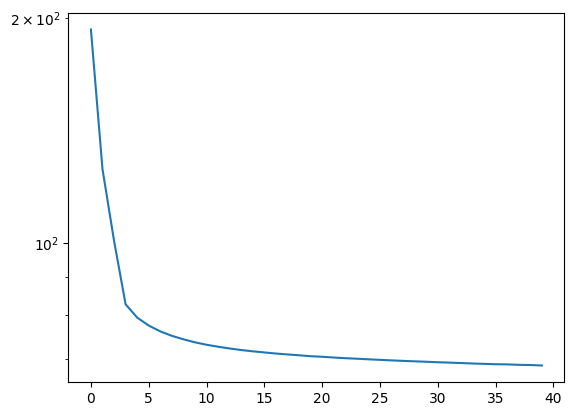

In [11]:
plt.plot(history)
plt.yscale('log')
plt.show()